# 0. IMPORT DEPENDENCIES

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

from data_plot import *

In [2]:
df = pd.read_excel("./data/dining area.xlsx")
df.head(3)

,Unnamed: 0,epochtime,datatype,value,unit,control,min_value,max_value
0,0,2022-04-22 22:05:00,temperature,22.1,Celcius,indirect,NaN,NaN
1,1,2022-04-22 22:05:00,luminosity,0.0,Lux,indirect,0.0,NaN
2,2,2022-04-22 22:05:00,humidity,49.0,%,indirect,0.0,100.0


# 1. Check data, duplicates, NaNs


In [3]:
df.duplicated().sum()

np.int64(0)

In [4]:
df.isna().sum()

Unnamed: 0        0
epochtime         0
datatype          0
value             0
unit          66439
control           0
min_value     39747
max_value     79363
dtype: int64

Check `duplicates`, `nan`:
- `Duplicates`: không chứa dữ liệu lặp.
- `NaN`: có chứa nhưng chỉ chứa đối với cột `unit`, `min_value`, `max_value` nên không ảnh hưởng.

# 2. Standardization



## 2.1. Thống nhất đơn vị dữ liệu

In [5]:
datatypes = df["datatype"].unique()
for datatype in datatypes:
    rows = df[df["datatype"] == datatype]
    units = rows["unit"].unique()
    controls = rows["control"].unique()
    print(f"{datatype}:\n   - {units}\n   - {controls}\n")

temperature:
   - ['Celcius']
   - ['indirect' 'direct']

luminosity:
   - ['Lux']
   - ['indirect']

humidity:
   - ['%']
   - ['indirect']

motion:
   - [nan]
   - ['no']

acoustic:
   - ['dBm']
   - ['indirect']



Có thể thấy:
- `Temperature`: 
    - `Unit`: `Celsius`
    - `Control`: `indirect`, `direct`

- `Luminosity`:
    - `Unit`: `Lux`
    - `Control`: `indirect`

- `Humidity`:
    - `Unit`: `%`
    - `Control`: `indirect`
  
- `Motion`:
    - `Unit`: không có do `Motion` thể hiện tại thời điểm đó, zone có người hay không có người
    - `Control`: `no`
  
- `Acoustic`:
    - `Unit`: `dBm`
    - `Control`: `indirect`.

Do các loại dữ liệu không có nhiều hơn 1 kiểu đơn vị nên không cần thống nhất đơn vị.

## 2.2. Epochtime thành Datetime

In [6]:
def str2datetime(epochtime):
    return datetime.strptime(epochtime, '%Y-%m-%d %H:%M:%S')

In [7]:
df["epochtime"] = df["epochtime"].apply(str2datetime)
df.head(2)

,Unnamed: 0,epochtime,datatype,value,unit,control,min_value,max_value
0,0,2022-04-22 22:05:00,temperature,22.1,Celcius,indirect,NaN,NaN
1,1,2022-04-22 22:05:00,luminosity,0.0,Lux,indirect,0.0,NaN


# 3. Data segmentation

## 3.1. Kiểm tra số lượng mẫu dữ liệu

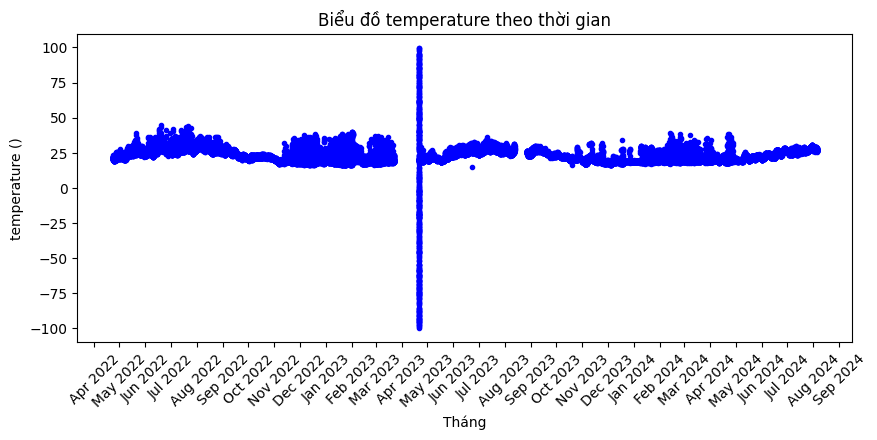

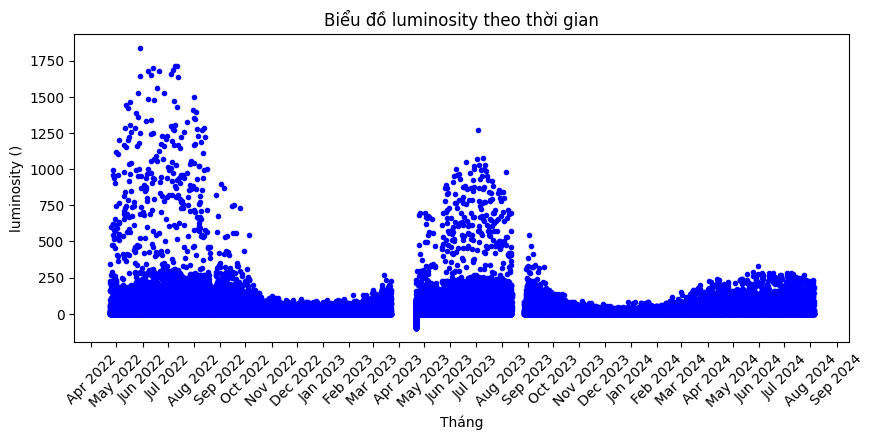

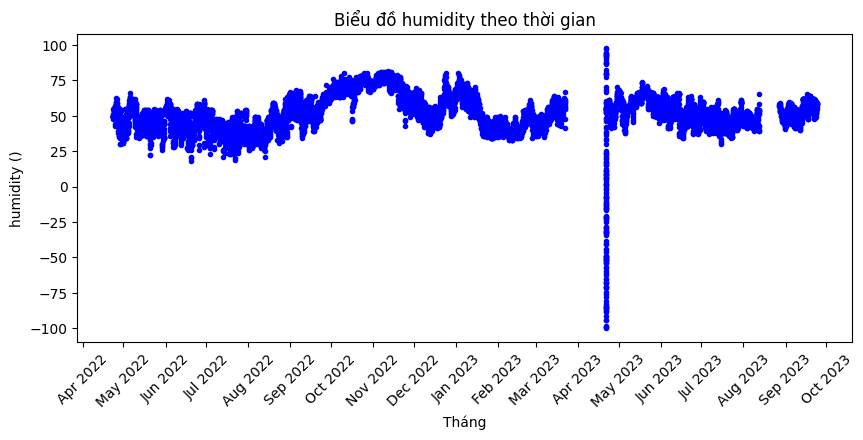

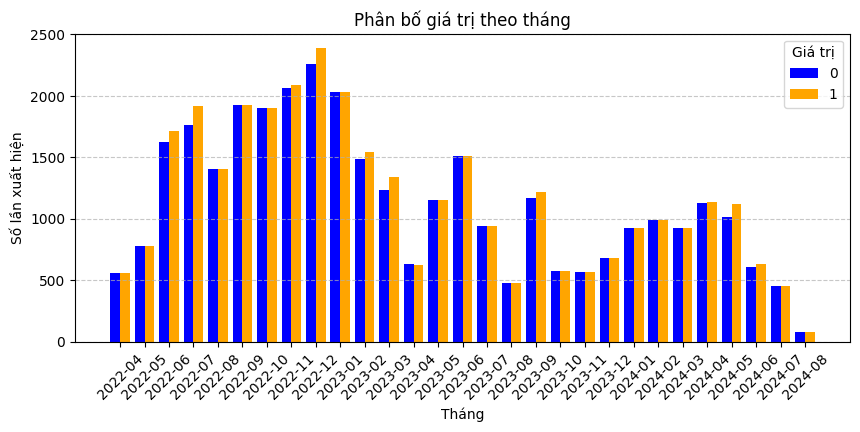

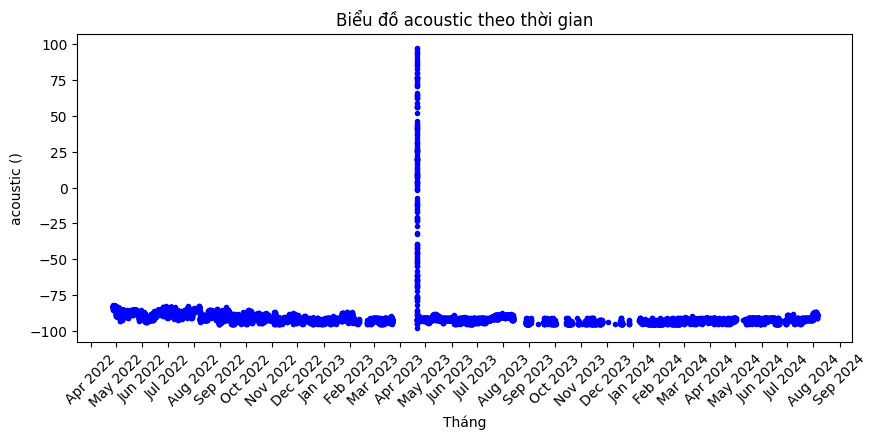

In [8]:
for datatype in datatypes:
    rows = df[df["datatype"] == datatype]

    if datatype != "motion":
        time, value = rows["epochtime"], rows["value"]
        lineplot(time, value, {"datatype": datatype, "unit": ""})
    
    else:
        barplot(rows["epochtime"], rows["value"])

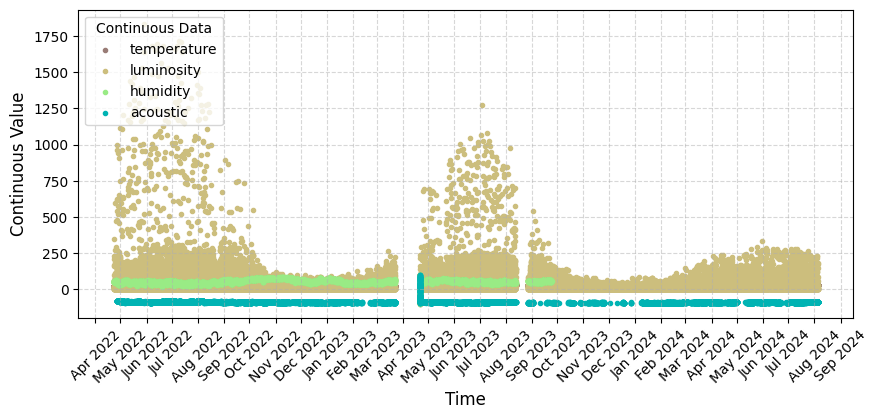

In [9]:
multi_scatterplot(df)

Có thể thấy:

|Loại dữ liệu|Số mẫu dữ liệu|Tháng bắt đầu thu dữ liệu|Tháng kết thúc thu dữ liệu|
|---|---|---|---|
|`Humidity`|9458|4/2022|10/2023|
|`Temperature`|39747|4/2022|9/2024|
|`Luminosity`|26936|4/2022|9/2024|
|`Acoustic`|12680|4/2023|9/2024|
|`Motion`|66439|4/2022|9/2024|

Lưu ý:
- Khoảng thời gian thu dữ liệu của các loại dữ liệu chủ yếu bắt đầu từ 4/2022 đến 10/2024, chỉ mỗi loại dữ liệu `Humidity` chỉ được thu đến 10/2023

Vì vậy, chỉ lấy dữ liệu trong khoảng có đủ toàn bộ loại dữ liệu: `5/2022` - `8/2023`

- Có 2 khoảng thời gian trống mà không có loại dữ liệu nào được thu

Vì vậy, tách đoạn dữ liệu thành 3 khoảng thời gian thu liên tục

## 3.2. Chọn timestamp

In [10]:
start_date = "2022-05-01"
end_date = "2023-08-31"

segment_df = df[
    (df["epochtime"] >= start_date) & 
    (df["epochtime"] <= end_date)
][["epochtime", "datatype", "value", "control"]].reset_index(drop = True)

segment_df.head(2)

,epochtime,datatype,value,control
0,2022-05-01 00:45:00,luminosity,0.00,indirect
1,2022-05-01 00:45:00,humidity,46.61,indirect


In [11]:
def avg_time_diff(df, plot = False):
    epochtimes = sorted(df["epochtime"].unique())

    time_diffs_min = []
    for i in range(len(epochtimes) - 1):
        interval = (epochtimes[i + 1] - epochtimes[i]).total_seconds() / 60
        if interval > 20000:
            print(f"Thời gian từ {epochtimes[i]} đến {epochtimes[i + 1]}: {interval / (60 * 24):.2f} ngày")
            continue

        time_diffs_min.append(interval)

    avg_interval = np.mean(time_diffs_min)

    print(f"Trung bình khoảng cách giữa các 2 lần đo dữ liệu: {avg_interval:.2f} phút")

    if plot:
        boxplot(pd.DataFrame(time_diffs_min, columns = ["Giữa 2 lần đo (phút)"]))

HUMIDITY
Thời gian từ 2023-03-22 13:35:00 đến 2023-04-21 09:53:10: 29.85 ngày
Thời gian từ 2023-08-12 17:00:00 đến 2023-08-27 10:55:00: 14.75 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 72.20 phút


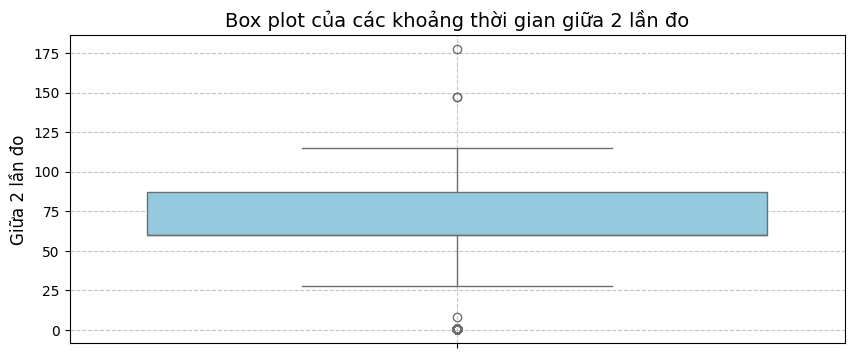

----------------------------------------------
LUMINOSITY
Thời gian từ 2023-03-22 13:35:00 đến 2023-04-21 09:53:10: 29.85 ngày
Thời gian từ 2023-08-12 17:05:00 đến 2023-08-27 10:55:00: 14.74 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 35.82 phút


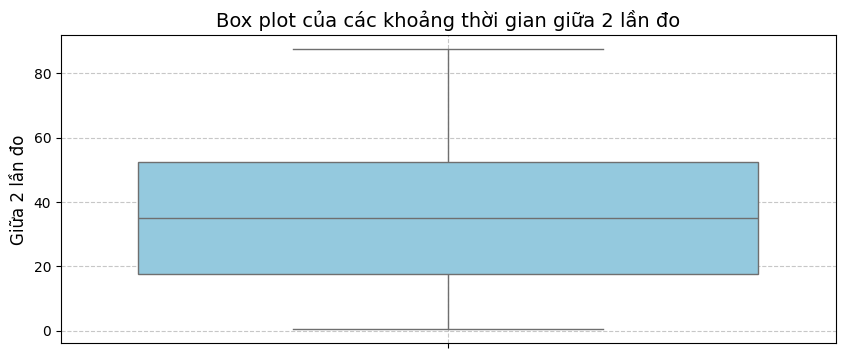

----------------------------------------------
ACOUSTIC
Thời gian từ 2023-03-22 13:40:00 đến 2023-04-21 09:53:10: 29.84 ngày
Thời gian từ 2023-08-12 17:30:00 đến 2023-08-27 11:30:00: 14.75 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 72.05 phút


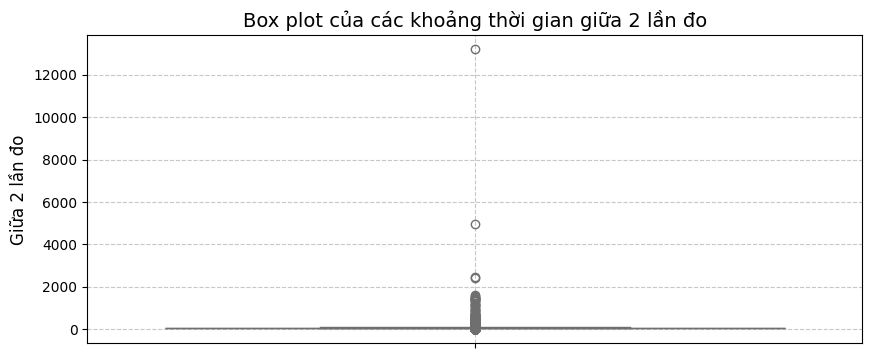

----------------------------------------------
TEMPERATURE
Thời gian từ 2023-03-22 13:40:00 đến 2023-04-21 09:53:10: 29.84 ngày
Thời gian từ 2023-08-12 17:30:00 đến 2023-08-27 10:55:00: 14.73 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 24.51 phút


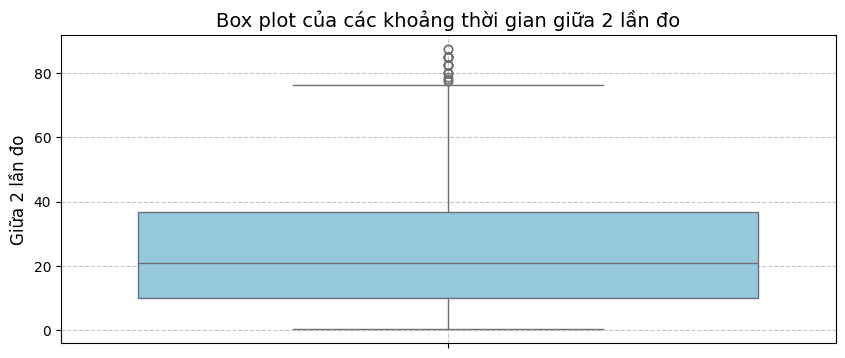

----------------------------------------------
MOTION
Thời gian từ 2023-03-22 13:55:17 đến 2023-04-21 09:53:10: 29.83 ngày
Thời gian từ 2023-08-12 17:41:24 đến 2023-08-27 10:43:37: 14.71 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 13.65 phút


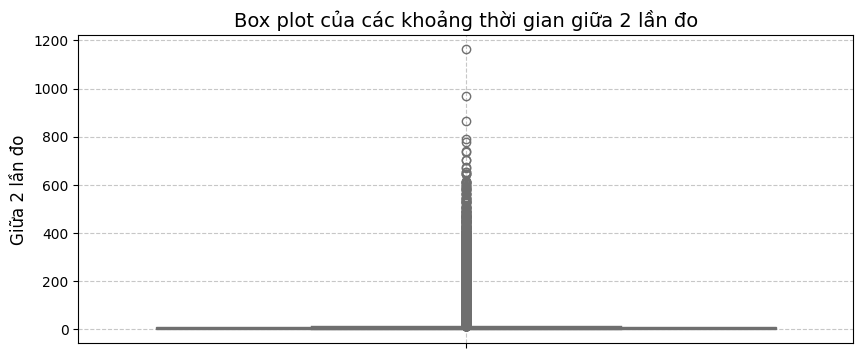

----------------------------------------------


In [12]:
print(f"HUMIDITY")
avg_time_diff(segment_df[
    segment_df["datatype"] == "humidity"
], True)
print(f"----------------------------------------------")
print(f"LUMINOSITY")
avg_time_diff(segment_df[
    segment_df["datatype"] == "luminosity"
], True)
print(f"----------------------------------------------")
print(f"ACOUSTIC")
avg_time_diff(segment_df[
    segment_df["datatype"] == "acoustic"
], True)
print(f"----------------------------------------------")
print(f"TEMPERATURE")
avg_time_diff(segment_df[
    segment_df["datatype"] == "temperature"
], True)
print(f"----------------------------------------------")
print(f"MOTION")
avg_time_diff(segment_df[
    segment_df["datatype"] == "motion"
], True)
print(f"----------------------------------------------")

Có thể thấy 2 khoảng thời gian trống mà không loại dữ liệu nào được thu bao gồm:

- Từ ngày `22/3/2023` đến `21/4/2023`: xấp xỉ 30 ngày
- Từ ngày `12/8/2023` đến `27/8/2023`: xấp xỉ 15 ngày

Đây là điểm cắt chuỗi thời gian tổng thành 3 chuỗi thời gian nhỏ hơn

|Loại dữ liệu|Thời gian đo trung bình (phút)|
|---|---|
|Humidity|72.2|
|Luminosity|35.82|
|Acoustic|72.05|
|Temperature|24.51|
|Motion|13.65|


Kết hợp 2 bảng, ta có bản tổng kết như sau:
|Loại dữ liệu|Số mẫu dữ liệu|Thời gian đo trung bình (phút)|Tháng bắt đầu thu dữ liệu|Tháng kết thúc thu dữ liệu|
|------------|--------------|------------------------------|-------------------------|--------------------------|
|`Humidity`|9458|72.2|4/2022|10/2023|
|`Temperature`|39747|24.51|4/2022|9/2024|
|`Luminosity`|26936|35.82|4/2022|9/2024|
|`Acoustic`|12680|72.05|4/2023|9/2024|
|`Motion`|66439|13.65|4/2022|9/2024|

Lưu ý:
- Để đảm bảo mỗi timestamp có ít nhất 1 giá trị của mỗi datatype, cần chọn timestamp = max(thời gian đo trung bình của datatypes). Tuy nhiên, do yêu cầu bài toán, timestamp được chọn bằng 30 phút.
- Do số lượng mẫu dữ liệu của `Acoustic` nhỏ hơn hẳn so với lượng mẫu dữ liệu của các dữ liệu còn lại. Vì vậy, ta xem xét bỏ qua trường dữ liệu này.


Vì vậy chọn: 
- `Timestamp` = 30 phút 
- `Data`: bỏ `Acoustic`

In [24]:
# Bỏ acoustic
filtered_acoustic = segment_df[
    segment_df["datatype"] != "acoustic"
]

datatypes = filtered_acoustic["datatype"].unique()

In [25]:
# Time segmentation 1
start_date = "2022-05-01"

first_start_gap = "2023-3-21"
first_end_gap = "2023-4-22"

second_start_gap = "2023-8-11"
second_end_gap = "2023-8-28"

end_date = "2023-08-31"

first_gap = pd.date_range(start = start_date, end = first_start_gap, freq = "30min")
second_gap = pd.date_range(start = first_end_gap, end = second_start_gap, freq = "30min")
third_gap = pd.date_range(start = second_end_gap, end = end_date, freq = "30min")

timestamps = first_gap.union(second_gap).union(third_gap)
timestamps

DatetimeIndex(['2022-05-01 00:00:00', '2022-05-01 00:30:00',
               '2022-05-01 01:00:00', '2022-05-01 01:30:00',
               '2022-05-01 02:00:00', '2022-05-01 02:30:00',
               '2022-05-01 03:00:00', '2022-05-01 03:30:00',
               '2022-05-01 04:00:00', '2022-05-01 04:30:00',
               ...
               '2023-08-30 19:30:00', '2023-08-30 20:00:00',
               '2023-08-30 20:30:00', '2023-08-30 21:00:00',
               '2023-08-30 21:30:00', '2023-08-30 22:00:00',
               '2023-08-30 22:30:00', '2023-08-30 23:00:00',
               '2023-08-30 23:30:00', '2023-08-31 00:00:00'],
              dtype='datetime64[ns]', length=21027, freq=None)

In [26]:
segmented_data = []
cnt = 0
for i in tqdm(range(len(timestamps) - 1)):
    start = timestamps[i]
    end = timestamps[i + 1]

    segment = filtered_acoustic[
        (filtered_acoustic["epochtime"] >= start) &
        (filtered_acoustic["epochtime"] < end)
    ]

    if segment.empty:
        cnt += 1
  
    segmented_data.append(segment)

print(f"Có {cnt} khoảng thời gian không có dữ liệu!")

  0%|          | 0/21026 [00:00<?, ?it/s]

100%|██████████| 21026/21026 [00:16<00:00, 1294.68it/s]

Có 1218 khoảng thời gian không có dữ liệu!


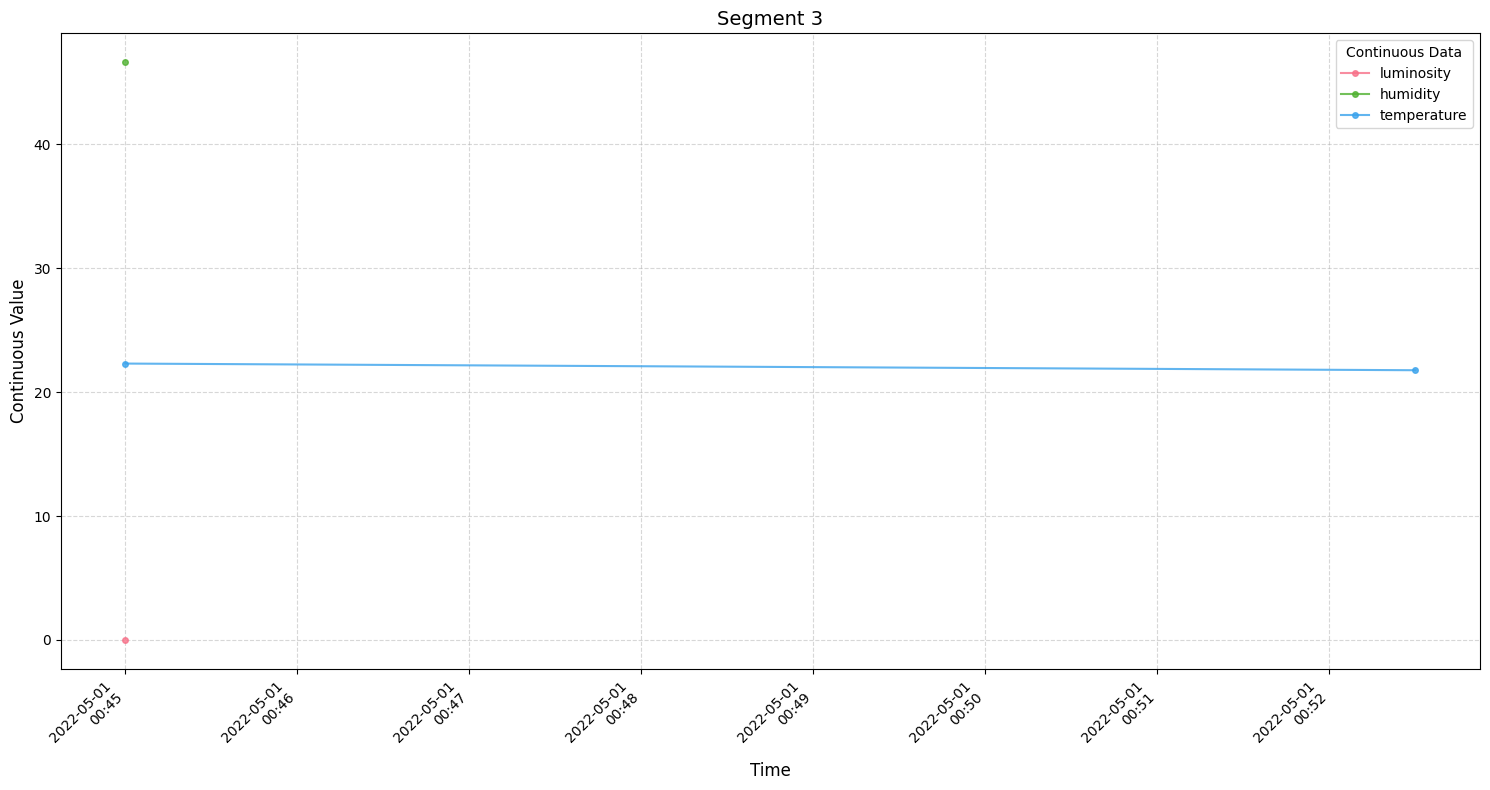

In [27]:
multi_lineplot(segmented_data[1], "Segment 3")

In [28]:
df_data = {
    "start_time": [],
    "end_time": [],
    "temperature": [],
    "luminosity": [],
    "humidity": [],
    "motion": []
}

cnt = 0
for i in tqdm(range(len(timestamps) - 1)):
    start_time = timestamps[i]
    end_time = timestamps[i + 1]

    segment = filtered_acoustic[
        (filtered_acoustic["epochtime"] >= start_time) &
        (filtered_acoustic["epochtime"] < end_time)
    ]

    if segment.empty:
        df_data["start_time"].append(start_time)
        df_data["end_time"].append(end_time)
        for datatype in datatypes:
            df_data[datatype].append(pd.NA)
        
        continue

    df_data["start_time"].append(start_time)
    df_data["end_time"].append(end_time)
    
    for datatype in datatypes:
        if datatype == "acoustic":
            continue
        
        data_rows = segment[
            segment["datatype"] == datatype
        ]

        if segment.empty:
            df_data[datatype].append(pd.NA)
        
        if datatype != "motion":
            df_data[datatype].append(
                data_rows["value"].mean()
            )
        else:
            df_data[datatype].append(
                data_rows["value"].sum()
            )

100%|██████████| 21026/21026 [00:36<00:00, 575.46it/s]


In [29]:
expected_df = pd.DataFrame(df_data)
expected_df.head(10)

,start_time,end_time,temperature,luminosity,humidity,motion
0,2022-05-01 00:00:00,2022-05-01 00:30:00,<NA>,<NA>,<NA>,<NA>
1,2022-05-01 00:30:00,2022-05-01 01:00:00,22.03125,0.0,46.61,0.0
2,2022-05-01 01:00:00,2022-05-01 01:30:00,<NA>,<NA>,<NA>,<NA>
3,2022-05-01 01:30:00,2022-05-01 02:00:00,22.2,0.0,48.0,0.0
4,2022-05-01 02:00:00,2022-05-01 02:30:00,21.53,NaN,NaN,0.0
5,2022-05-01 02:30:00,2022-05-01 03:00:00,NaN,0.0,NaN,1.0
6,2022-05-01 03:00:00,2022-05-01 03:30:00,21.615,NaN,48.5,0.0
7,2022-05-01 03:30:00,2022-05-01 04:00:00,NaN,NaN,NaN,1.0
8,2022-05-01 04:00:00,2022-05-01 04:30:00,21.1,3.0,NaN,0.0
9,2022-05-01 04:30:00,2022-05-01 05:00:00,21.6,NaN,49.0,0.0


In [31]:
# Check giá trị nan trong dữ liệu đơn lẻ nhiều chiều
expected_df.isna().sum()

start_time         0
end_time           0
temperature     4300
luminosity      6992
humidity       12446
motion          1218
dtype: int64

### 3.3. Khôi phục dữ liệu

Khôi phục dữ liệu sử dụng `Interpolation` và một số quy định khác như:
- Đối với dữ liệu liên tục: 
    - Chọn xây dựng `Multi Linear Regression` với x: time, y: data.
    - Sử dụng `Linear Interpolation`.

- Đối với dữ liệu trigger:
    - `Motion`: Không có dữ liệu = Không có ai đi qua ==> 0
    - `Window`: Không có dữ liệu = Dữ liệu không thay đổi ==> Dữ liệu trước đó

In [32]:
humidity_df = expected_df[["start_time", "end_time", "humidity"]]
humidity_df.head(10)

,start_time,end_time,humidity
0,2022-05-01 00:00:00,2022-05-01 00:30:00,<NA>
1,2022-05-01 00:30:00,2022-05-01 01:00:00,46.61
2,2022-05-01 01:00:00,2022-05-01 01:30:00,<NA>
3,2022-05-01 01:30:00,2022-05-01 02:00:00,48.0
4,2022-05-01 02:00:00,2022-05-01 02:30:00,NaN
5,2022-05-01 02:30:00,2022-05-01 03:00:00,NaN
6,2022-05-01 03:00:00,2022-05-01 03:30:00,48.5
7,2022-05-01 03:30:00,2022-05-01 04:00:00,NaN
8,2022-05-01 04:00:00,2022-05-01 04:30:00,NaN
9,2022-05-01 04:30:00,2022-05-01 05:00:00,49.0


In [ ]:
from multi_linear_regression import multi_lr

X, y = multi_lr.read_df(
    time = humidity_df[["start_time", "end_time"]],
    value = humidity_df["humidity"]
)

(array([[ 0.        ,  1.        ,  0.13052619,  0.99144486],
        [ 0.13052619,  0.99144486,  0.25881905,  0.96592583],
        [ 0.25881905,  0.96592583,  0.38268343,  0.92387953],
        ...,
        [-0.38268343,  0.92387953, -0.25881905,  0.96592583],
        [-0.25881905,  0.96592583, -0.13052619,  0.99144486],
        [-0.13052619,  0.99144486,  0.        ,  1.        ]],
       shape=(21026, 4)),
 array([<NA>, np.float64(46.61), <NA>, ..., nan, nan, np.float64(48.0)],
       shape=(21026,), dtype=object))